# MNIST with CNN

In [1]:
#load everything
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import sys, time
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

#change this five times to get 5 cross validation
SEED = 999
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cpu


## 1. ETL : Load the MNIST

In [3]:
transform = transforms.ToTensor()
#you guy need to me after this guy, the values becomes what
#value will be normalized to {0,1} and also converts to tensor

In [4]:
import os
os.environ['http_proxy'] = 'http://192.41.170.23:3128'
os.environ['https_proxy'] = 'http://192.41.170.23:3128'

train_data = datasets.MNIST(root="../data/",train=True,download=True,transform= transform)
#split the train into train and val
#this time, Chaky won't be be lazy, he will create validation set, which everyone MUST
len(train_data)

60000

In [5]:
train_set,val_set = torch.utils.data.random_split(train_data,[50000,10000])
len(train_set), len(val_set)

(50000, 10000)

In [6]:
test_set  = datasets.MNIST(root="../data/",train=False,download=True,transform= transform)
len(test_set)

10000

8

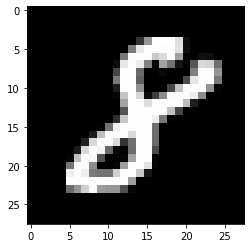

In [7]:
#challenge, show one image of a number
train_set[0][0].shape

#hint: plt.imshow()
plt.imshow(train_set[0][0].reshape(28,28),cmap='gray')

#what is the label of this guy?
train_set[0][1]

## 2. Create Dataloaders

In [8]:
#train batch_size = 10
#val batch_size = everything
#test batch_size = everything
#all shuffle = True

#format: DataLoader(dataset, batch_size, shuffle)
batch_size = 512

#format Dataloader(dataset,batch_size, shuffle)
train_loader = DataLoader(train_set, batch_size = batch_size, shuffle=True)
val_loader   = DataLoader(val_set, batch_size = len(val_set), shuffle=True)
test_loader  = DataLoader(test_set, batch_size = len(test_set), shuffle=True)

## Test the dataloader

In [9]:
# run a for loop train_loader and then break, and then print out shape of image,label
for images,labels in train_loader:
    print(images.shape) 
    print(labels.shape) 
    break

#what is [10, 1, 28, 28]
#        [batch_size, c, w, h] = image
#what is [10]
#        [batch_size] = target

torch.Size([10, 1, 28, 28])
torch.Size([10])


## 3. Learn about nn.Conv2d

In [10]:
#format: nn.Conv2d(input_channel, output_channel, kernel_size, stride = 1,padding=0)
#if i know my image is chanel 1
#let's say I want to convert this channel 1 to 13,
#kernel_size = 3
#stride = 1
#padding = 0
CNN_layer = nn.Conv2d(1, 13, 3, 1, 0)
CNN_layer

Conv2d(1, 13, kernel_size=(3, 3), stride=(1, 1))

In [11]:
CNN_layer.weight.shape #kernel,feature

torch.Size([13, 1, 3, 3])

In [12]:
# CNN_layer.bias.shape

In [13]:
#can you take image for me
image = train_set[0][0]
image.shape

torch.Size([1, 28, 28])

In [14]:
out = CNN_layer(image)
out.shape
#where does [13, 26, 26] comes from???
#(input_size - k +2p )/s +1
# (28 -3 + 2*0)/1 +1

torch.Size([13, 26, 26])

In [15]:
#can you create another convolution layer
#that can accept this input [13,26,26]
#kernel size = 3, stride = 1, padding = 0, output_channel = 5, input_channel = ???
#format: nn.Conv2d(input_channel, output_channel, kernel_size, stride = 1,padding=0)
CNN_layer2 = nn.Conv2d(13, 5, 3, 1, 0)
#test the layer
out2 = CNN_layer2(out)
out2.shape
# (28 - 5 + 2*0)/1 + 1

torch.Size([5, 24, 24])

In [16]:
image.shape

torch.Size([1, 28, 28])

In [17]:
#create two convolutional layer
#of outputchannel 256, then 128
#kernel_size 5, stride = 1, padding = 0

#layers = nn.Sequential(nn.Conv2d(1, 256, 5, 1, 0),nn.Conv2d(256, 128, 5, 1, 0))
#output = layers(image)
CNN_layer3 = nn.Conv2d(1, 256, 5, 1, 0)
out3 = CNN_layer3(image)
out3.shape

CNN_layer4 = nn.Conv2d(256, 128, 5, 1, 0)
out4 = CNN_layer4(out3)
out4.shape

#try to print out one channel of that image

torch.Size([128, 20, 20])

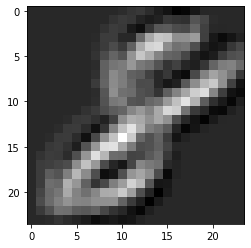

In [18]:
plt.imshow(out3[0].detach().numpy(),cmap='gray')

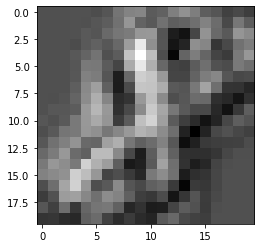

In [19]:
plt.imshow(out4[0].detach(),cmap='gray')

## 4.Learn about maxpool2d and batchnorm and droupout

In [20]:
pool = nn.MaxPool2d(2,2)

In [21]:
image.shape

torch.Size([1, 28, 28])

In [22]:
out = pool(image)
out.shape

torch.Size([1, 14, 14])

In [23]:
#test the sample
random_image = torch.rand((1,1,28,28))
conv1 = nn.Conv2d(1,6,3,1,0) 
conv2 = nn.Conv2d(6,16,3,1,0)

layers = nn.Sequential(conv1,conv2)
out = layers(random_image)
out.shape

torch.Size([1, 16, 24, 24])

## 5. Create the model

In [24]:
#convolutional neural network
#format: nn.Conv2d(input_channel, output_channel, kernel_size, stride = 1,padding=0)
class CNN(nn.Module):
    
    def __init__(self):
        super().__init__()
        #create 2 convolutional layer (1 -> 6 -> 16)
        #stride = 1, kernel_size = 3
        self.conv1 = nn.Conv2d(1, 6, 3, 1)  #(input_size - k + 2P) / s +1
        #input w/h = (28 - 3 + 0) / 1 + 1 = 26
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        #input w/h = (24 - 3 + 0) /1 + 1 = 24
        #three linear layers here
        #1st layer - from image (b, c, w, h) --> (b, c*w*h) in order to input to linear layer
        #1st layer input_size -> 120  (input_size here is channel x w x h)
        self.linear1 = nn.Linear(16*5*5, 120)
        #2nd layer 120 -> 84
        self.linear2 = nn.Linear(120, 84)
        #3rd layer 84 -> 10  (10 is the output_size)
        self.linear3 = nn.Linear(84, 10)
        
        self.maxpool = nn.MaxPool2d(2, 2)
        self.relu    = nn.ReLU()
        
    def forward(self, image):
        #image.shape:  (B, C, W, H)
        out = self.conv1(image)  #convolution1
        #out.shape:    (B, 6, 26, 26)
        out = self.relu(out) #relu
        out = self.maxpool(out) #maxpool2d
        #out.shape:    (B, 6, 13, 13)
        
        #(input_size - k + 2P) / s +1
        # 13 - 3 / 1 + 1 = 11
        out = self.conv2(out) #convolution2
        #out.shape (B, 16, 11, 11)
        out = self.relu(out) #relu
        out = self.maxpool(out) #maxpool2d
        #out.shape (B, 16, 5, 5)
        
        #reshape so that it can be inserted into the linear layer
        out = out.reshape(-1, 16*5*5)
        
        #linear1 -> relu
        #linear2 -> relu
        #linear3
        out = self.linear1(out)
        out = self.relu(out)
        #out.shape (B, 120)
        #linear2 -> relu
        out = self.linear2(out)
        out = self.relu(out)
        #out.shape (B, 84)
        #linear3 -> relu
        out = self.linear3(out)
        #out.shape (B, 10)
        
        return out

## 6. Test the model for me

In [25]:
model = CNN().to(device)
random_image = torch.rand((1,1,28,28)).to(device)
out = model(random_image)
out.shape
# assert out.shape = ()

torch.Size([1, 10])

## 7. Count the parameters

In [26]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

In [27]:
count_parameters(model)
#what is 54, 5, 864, 16 ... where does they come from
#total para,eter is 60074

#54 come from the first conv1 layer
#(1, 6, 3, 3) = 54
#6 come from the bias of the frist conv1 layer
#864 come from the first conv2 layer
#(6, 16, 3, 3) = 864
#48000
# (5*5*16,120) = 48000
#120 Bias

    54
     6
   864
    16
 48000
   120
 10080
    84
   840
    10
______
 60074


## 8. Training

In [28]:
# epochs    = 5
# J_fn      = nn.CrossEntropyLoss() 
# optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
# losses = []
# accs = []
# #for epoch
# for e in range(epochs):
#     total_corr = 0
#     for b, (image,label) in enumerate(train_loader):

#         start_time = time.time()
        
#         #image : (B,C, W,H)
#         #label : (B)
#         image = image.to(device) 
#         label = label.to(device) 

#         yhat = model(image) #1.model
#         loss = J_fn(yhat,label) #2. loss

#         #2.1 collect the loss and acc
#         losses.append(loss)
#         predicted = torch.max(yhat, 1)[1]
#         batch_corr = (predicted == label).sum()
#         total_corr += batch_corr 
#         #2.2 with torch.no_grad(): evaluate the valid_loader acc and loss
#         with torch.no_grad():
#             val_corr = 0 
#             for val_image,val_label in val_loader:
#                 val_yhat = model(val_image)
#                 val_loss = J_fn(val_yhat, val_label)
#                 val_predicted = torch.max(val_yhat, 1)[1]
#                 val_corr += (val_predicted == val_label).sum()
#             val_acc = val_corr*100 / len(val_set)
#         #here you MUST SAVE THE BEST MODEL whenever val_loss < val_old_loss

#         optimizer.zero_grad() #3. zero_grad
#         loss.backward() #4. backward
#         optimizer.step() #5. step

#         #print the loss and acc if epoch / 1
#         acc = (total_corr*100) / (10*(b+1))
#         accs.append(acc)
#         if b % 1000 == 1:
#             print(f'Epoch: {e}; Train Loss: {loss:.2f}; Valid Loss: {val_loss:3.2f}; Train Acc: {acc:.2f}; Valid Acc: {val_acc:3.2f}')

In [29]:
J_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [32]:
epochs = 5   #too lazy to wait
val_old_loss = float("Inf")
train_losses = []
train_accs   = []
val_losses   = []
val_accs     = []
filepath = '../models/best_mnist.pt'
#for epochs
for e in range(epochs):
    #for train loader
    total_corr = 0
    for b, (image, label) in enumerate(train_loader):
        
        start_time = time.time()
        
        #image: (B, C, W, H)
        #label: (B)
        image = image.to(device)
        label = label.to(device)
        
        yhat = model(image) #1. model
        train_loss = J_fn(yhat, label) #2. loss
        
        #2.1 collect the loss and acc
        train_losses.append(train_loss)
        predicted = torch.max(yhat, 1)[1]
        batch_corr = (predicted == label).sum()
        total_corr += batch_corr
            
        optimizer.zero_grad() #3. zero_grad
        train_loss.backward() #4. backward
        optimizer.step() #5. step
        
        #print the loss and acc if epoch / 1
        train_acc = (total_corr * 100) / (batch_size * (b + 1))
        train_accs.append(train_acc)
        
        #total time
        total_time = time.time() - start_time
        
        if (b+1) % 1000 == 0:
            print(f"Epoch: {e} - Batch: {b} - Train Loss: {train_loss:.2f} - Train Acc: {train_acc:.2f} - Total Time: {total_time:.2f}s")
        
    with torch.no_grad():
        val_corr = 0 
        for val_image, val_label in val_loader:
            val_image = val_image.to(device)
            val_label = val_label.to(device)
            val_yhat = model(val_image)
            val_loss = J_fn(val_yhat, val_label)
            val_predicted = torch.max(val_yhat, 1)[1]
            val_corr += (val_predicted == val_label).sum()
            if val_loss < val_old_loss: #save the model
                torch.save(model.state_dict(), filepath)
        val_acc = (val_corr * 100) / len(val_set)
    val_accs.append(val_acc)
    val_losses.append(val_loss)
    # here you MUST SAVE THE BEST MODEL whenever val_loss < val_old_loss
    ##even if it takes time, you want to do this in your thesis....
    
    print(f"++++++Validation++++++ Val Loss: {val_loss:.2f} - Val Acc: {val_acc:.2f}")

Epoch: 0 - Batch: 999 - Train Loss: 0.52 - Train Acc: 1.92 - Total Time: 0.00s
Epoch: 0 - Batch: 1999 - Train Loss: 0.00 - Train Acc: 1.92 - Total Time: 0.00s
Epoch: 0 - Batch: 2999 - Train Loss: 0.00 - Train Acc: 1.93 - Total Time: 0.00s
Epoch: 0 - Batch: 3999 - Train Loss: 0.00 - Train Acc: 1.93 - Total Time: 0.00s
Epoch: 0 - Batch: 4999 - Train Loss: 0.00 - Train Acc: 1.93 - Total Time: 0.00s
++++++Validation++++++ Val Loss: 0.05 - Val Acc: 98.45
Epoch: 1 - Batch: 999 - Train Loss: 0.00 - Train Acc: 1.94 - Total Time: 0.00s
Epoch: 1 - Batch: 1999 - Train Loss: 0.06 - Train Acc: 1.93 - Total Time: 0.00s
Epoch: 1 - Batch: 2999 - Train Loss: 0.00 - Train Acc: 1.93 - Total Time: 0.00s
Epoch: 1 - Batch: 3999 - Train Loss: 0.00 - Train Acc: 1.93 - Total Time: 0.00s
Epoch: 1 - Batch: 4999 - Train Loss: 0.01 - Train Acc: 1.93 - Total Time: 0.00s
++++++Validation++++++ Val Loss: 0.06 - Val Acc: 98.04
Epoch: 2 - Batch: 999 - Train Loss: 0.00 - Train Acc: 1.94 - Total Time: 0.00s
Epoch: 2 - Ba

In [33]:
train_losses = [loss.item() for loss in train_losses]
train_accs   = [acc.item()  for acc  in train_accs]
val_losses   = [loss.item() for loss in val_losses]
val_accs     = [acc.item()  for acc  in val_accs]

Text(0.5, 1.0, 'Loss/acc at the end of each epoch')

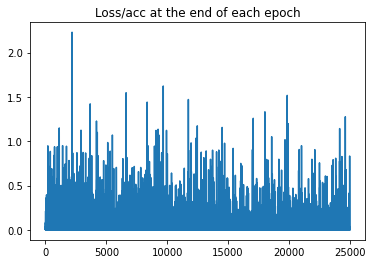

In [37]:
plt.plot(train_losses, label='training loss')
plt.legend()
plt.title('Loss/acc at the end of each epoch')

Text(0.5, 1.0, 'Loss/acc at the end of each epoch')

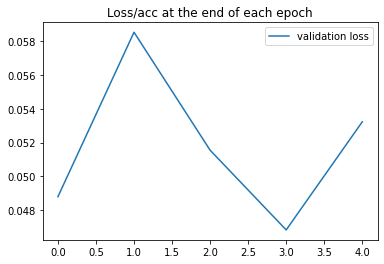

In [38]:
plt.plot(val_losses, label='validation loss')
plt.legend()
plt.title('Loss/acc at the end of each epoch')

Text(0.5, 1.0, 'Loss/acc at the end of each epoch')

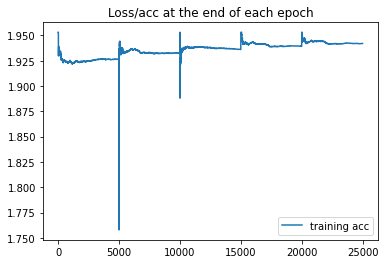

In [39]:
plt.plot(train_accs, label='training acc')
plt.legend()
plt.title('Loss/acc at the end of each epoch')

Text(0.5, 1.0, 'Loss/acc at the end of each epoch')

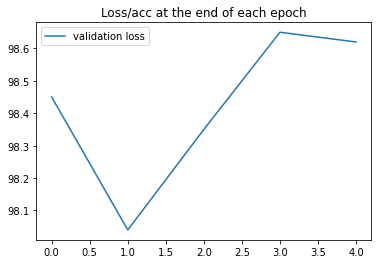

In [40]:
plt.plot(val_accs, label='validation loss')
plt.legend()
plt.title('Loss/acc at the end of each epoch')

## 9. Testing

In [41]:
#do by yourself
#load the best model based on val loss
model = CNN().to(device)
model.load_state_dict(torch.load(filepath)) #load the best modelfilepath

#do the testing phase! :-)
with torch.no_grad():
    test_corr = 0 
    for test_image, test_label in test_loader:
        test_image = test_image.to(device)
        test_label = test_label.to(device)
        test_yhat = model(test_image)
        test_loss = J_fn(test_yhat, test_label)
        test_predicted = torch.max(test_yhat, 1)[1]
        test_corr += (test_predicted == test_label).sum()
    test_acc = (test_corr * 100) / len(test_set)
    
print(test_acc)

tensor(98.6900)
